In [6]:
%load_ext autoreload
%autoreload 2
import os, pickle, csv, itertools, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torchvision, torch
from scipy import stats
import seaborn as sns

import warnings
import pathlib
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format='retina'

import utils.plot_data as plot
import models.transforms as transforms
import algorithms.teaching_algs as algs
from evals.teaching_evals import *
import utils.gen_triplets as gen
from CV_experiments.utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
df = pd.read_csv('CV_experiments/bm.prolific_experiments.csv')
dataset = 'bm'
dist = 'prolific'
alg_name = 'MMD'
m_range = np.arange(1,41)

### Comparing different learners, all using CONCAT

In [30]:
plot_configs = {     "1NN":                     {'c':"c", 'ls':"solid", 'marker':""}, 
                    "exemplar":             {'c':"y", 'ls':"dashdot", 'marker':"o"},
                    "CV":                   {'c':"r", 'ls':"solid", 'marker':"s"},
                    "CV_w=dist":            {'c':"g", 'ls':"dotted", 'marker':"^"},
                    "CV_w=ddiff":           {'c':"m", 'ls':"solid", 'marker':"x"},
                    }

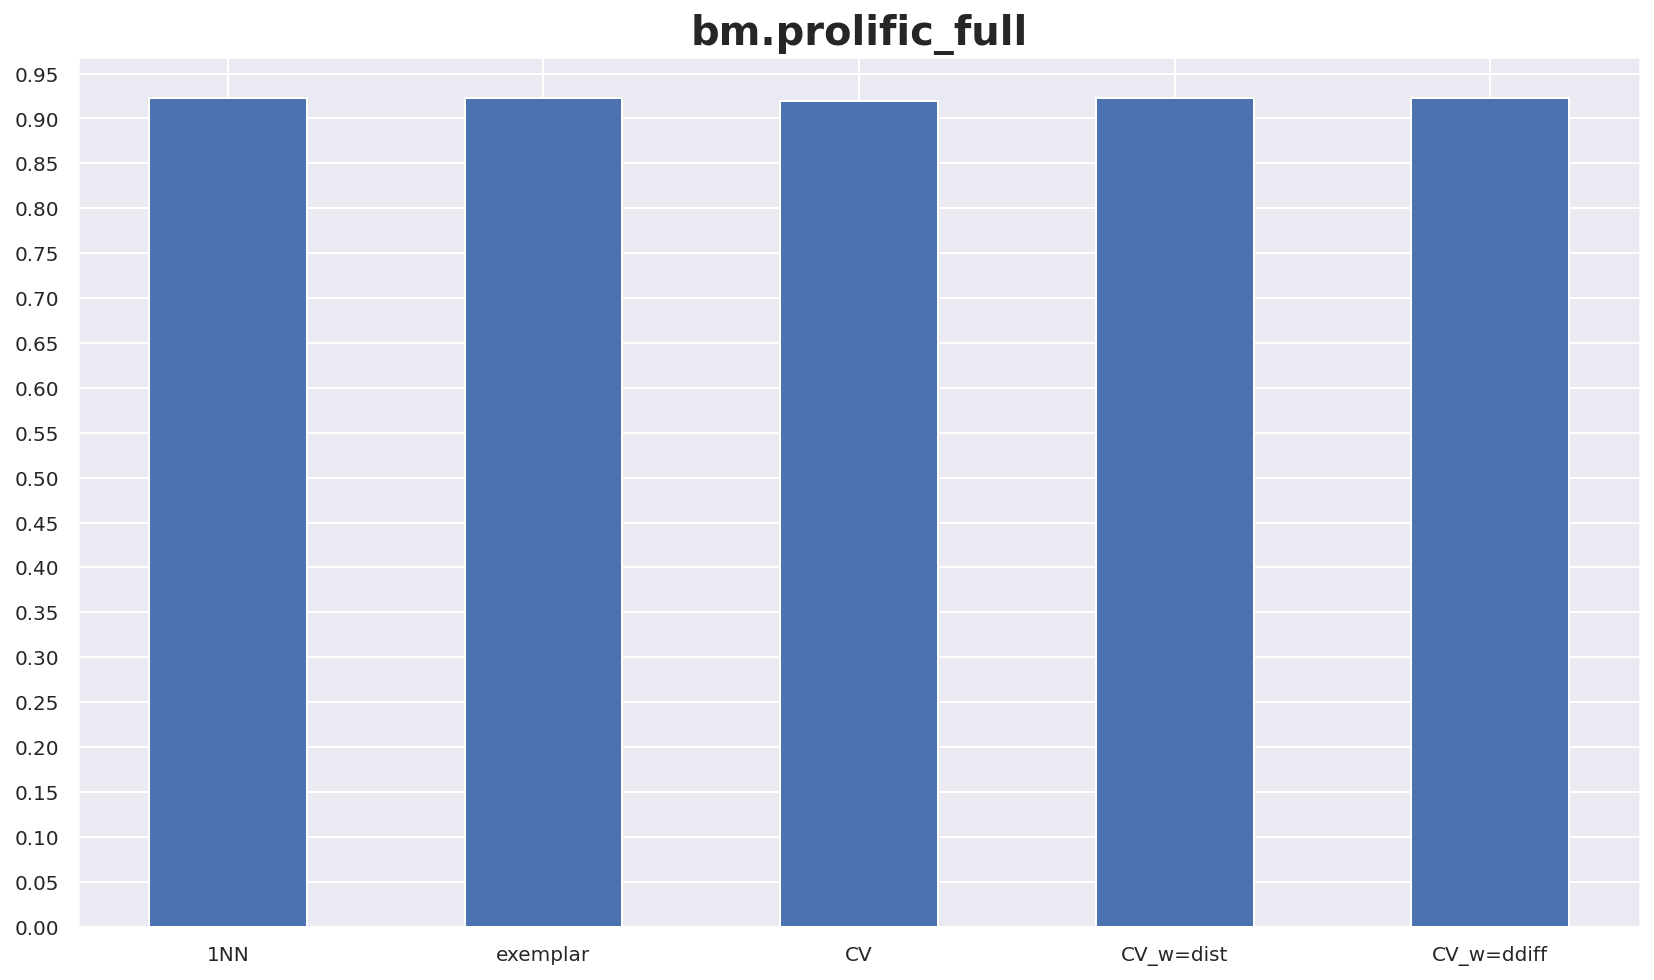

In [26]:
full_df = df[df['algorithm']=='full']
full_acc = {full_df.iloc[i]['learner']: full_df.iloc[i].to_list()[2:] for i in range(len(full_df))}
plot_full(full_acc, m_range, title = f"{dataset}.{dist}_full", plot_configs=plot_configs)

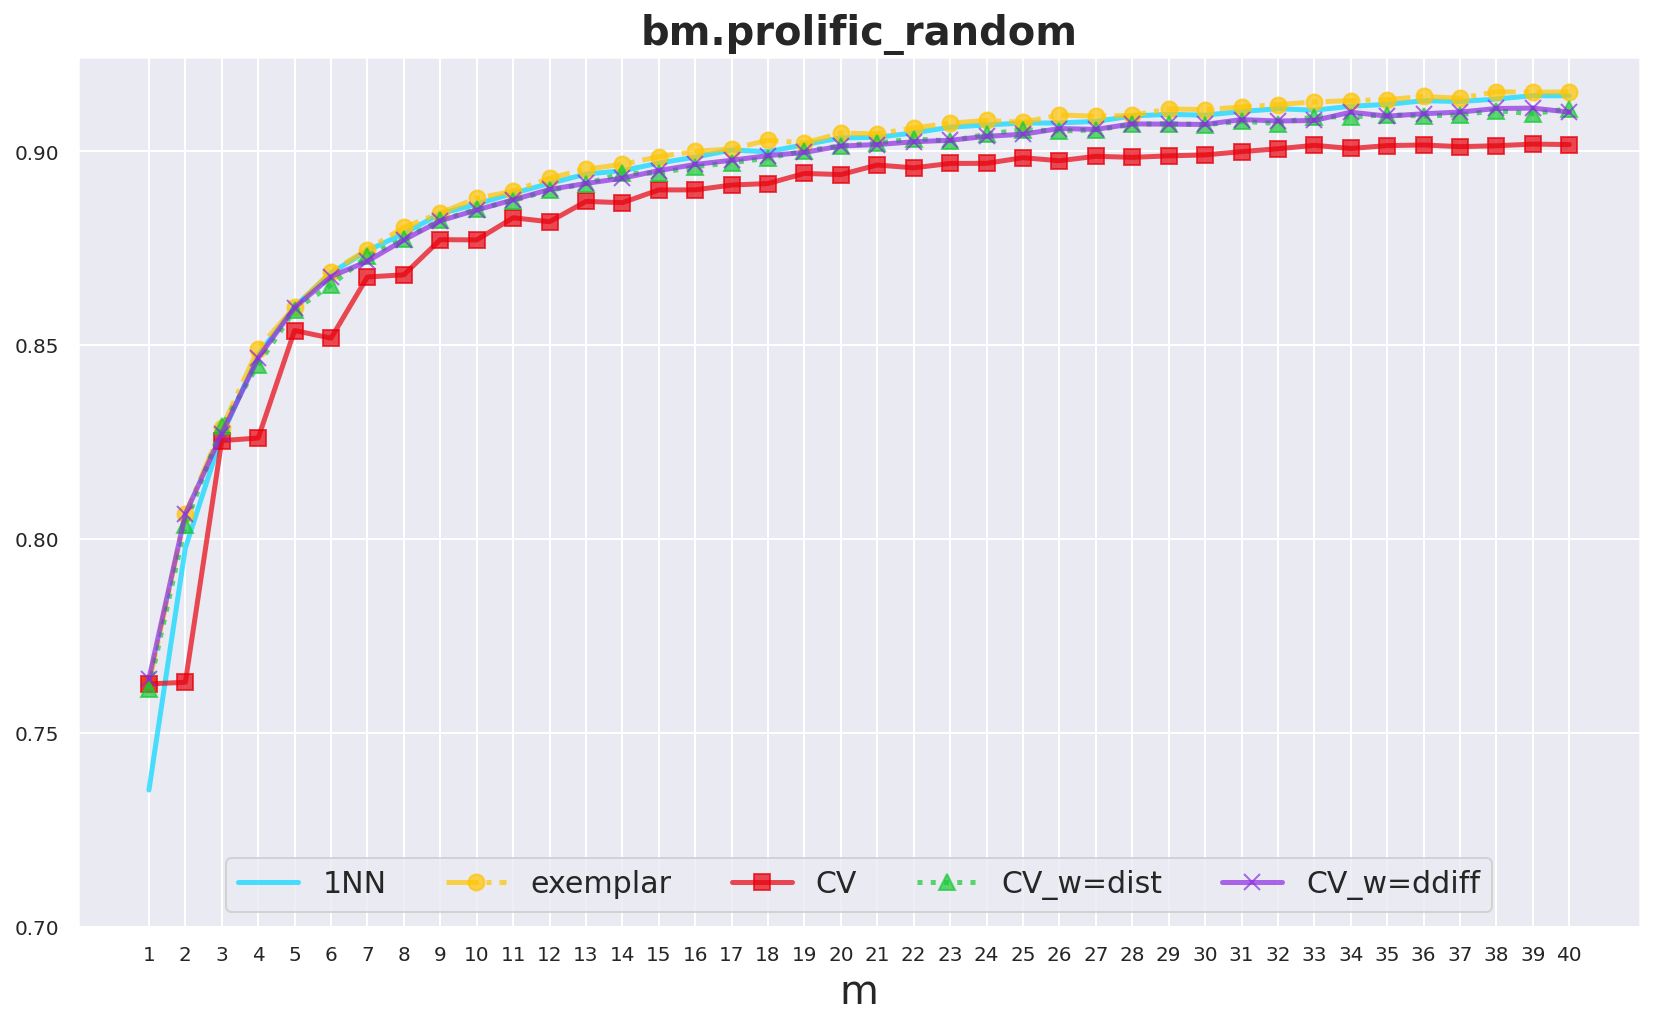

In [31]:
random_df = df[df['algorithm']=='random']
random_acc = {random_df.iloc[i]['learner']: random_df.iloc[i].to_list()[2:] for i in range(len(random_df))}
plot_random(random_acc, m_range, title=f"{dataset}.{dist}_random", plot_configs=plot_configs)

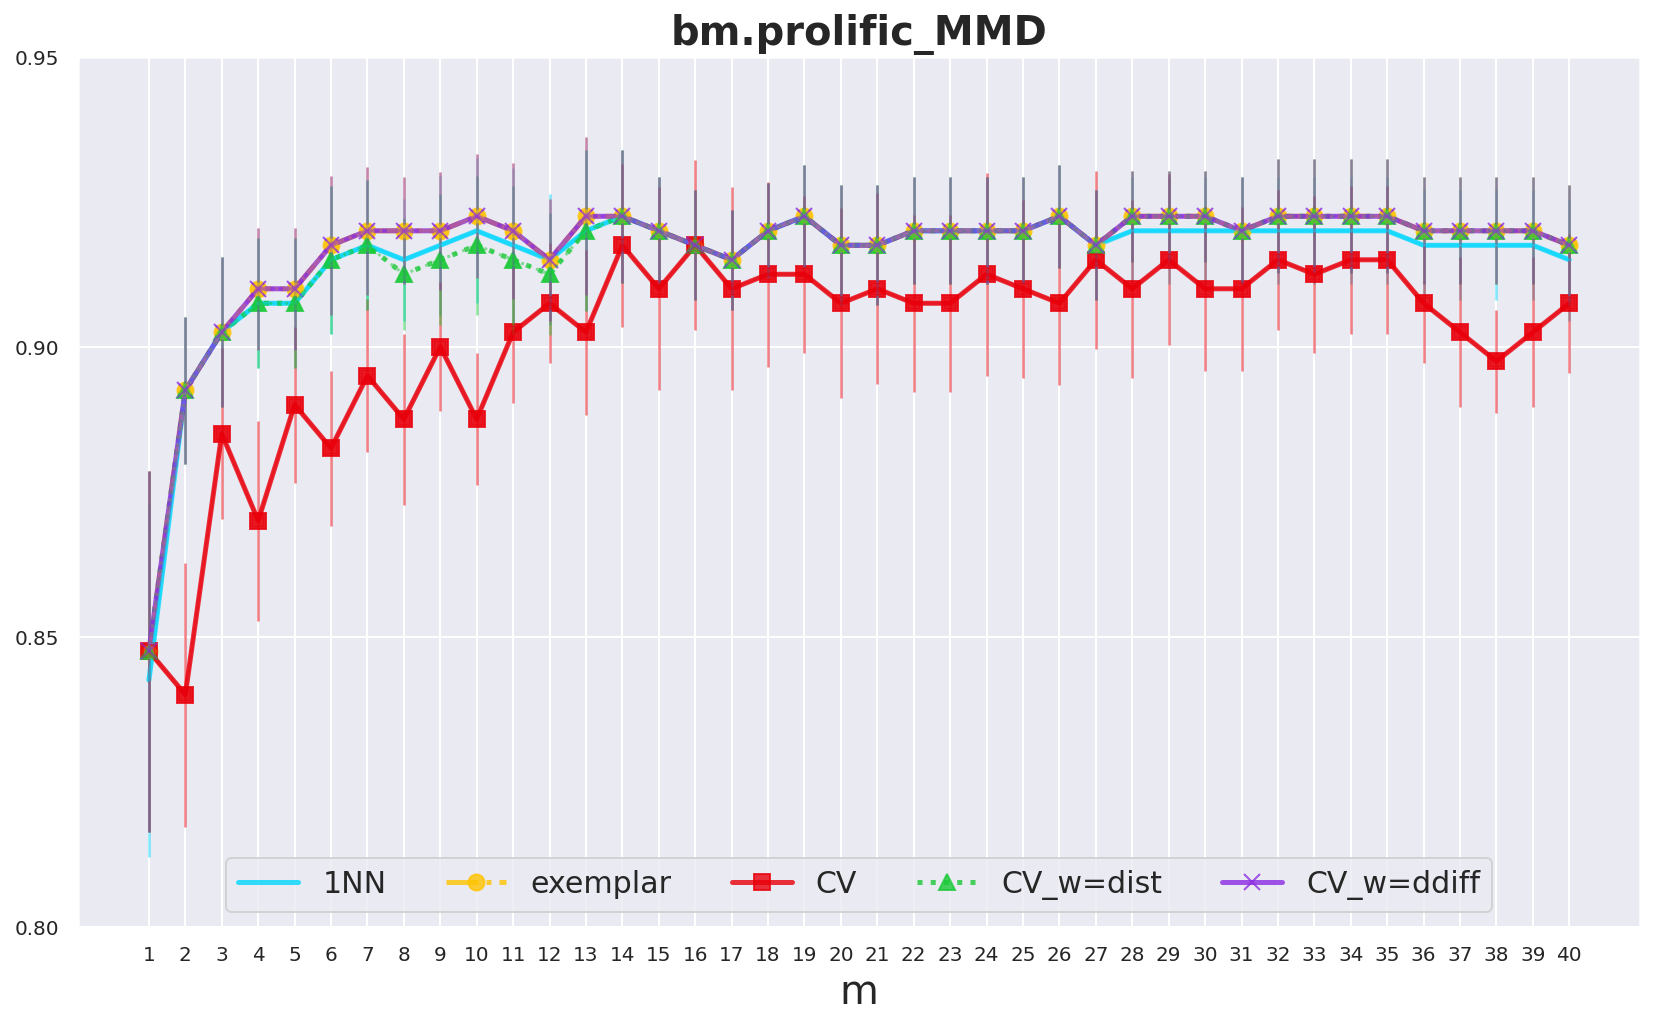

In [32]:
teach_df = df[df['algorithm']==alg_name]
teach_acc = {teach_df.iloc[i]['learner']: teach_df.iloc[i].to_list()[2:] for i in range(len(teach_df))}
teach_ste_df = df[df['algorithm']==f"{alg_name}_ste"]
teach_ste = {teach_ste_df.iloc[i]['learner']: teach_ste_df.iloc[i].to_list()[2:] for i in range(len(teach_ste_df))}
plot_teaching(teach_acc, m_range, title=f"{dataset}.{dist}_{alg_name}", plot_configs=plot_configs, ste=teach_ste)

### Comparing different teaching algorithms, all using CONCAT

In [17]:
save_dir = 'CV_experiments/figures/CONCAT_comp.alg'
pathlib.Path(save_dir).mkdir(parents=True, exist_ok=True)
save_fig = True
plot_configs = {     "full":          {'color': "k", 'lw': 2, 'ls':"dashed", 'marker': ""}, 
                "random":        {'color': "g", 'lw': 2, 'ls':"dashed", 'marker': ""},
                "teach":        {'color': "r", 'lw': 4, 'ls':"solid", 'marker': "^"},
}

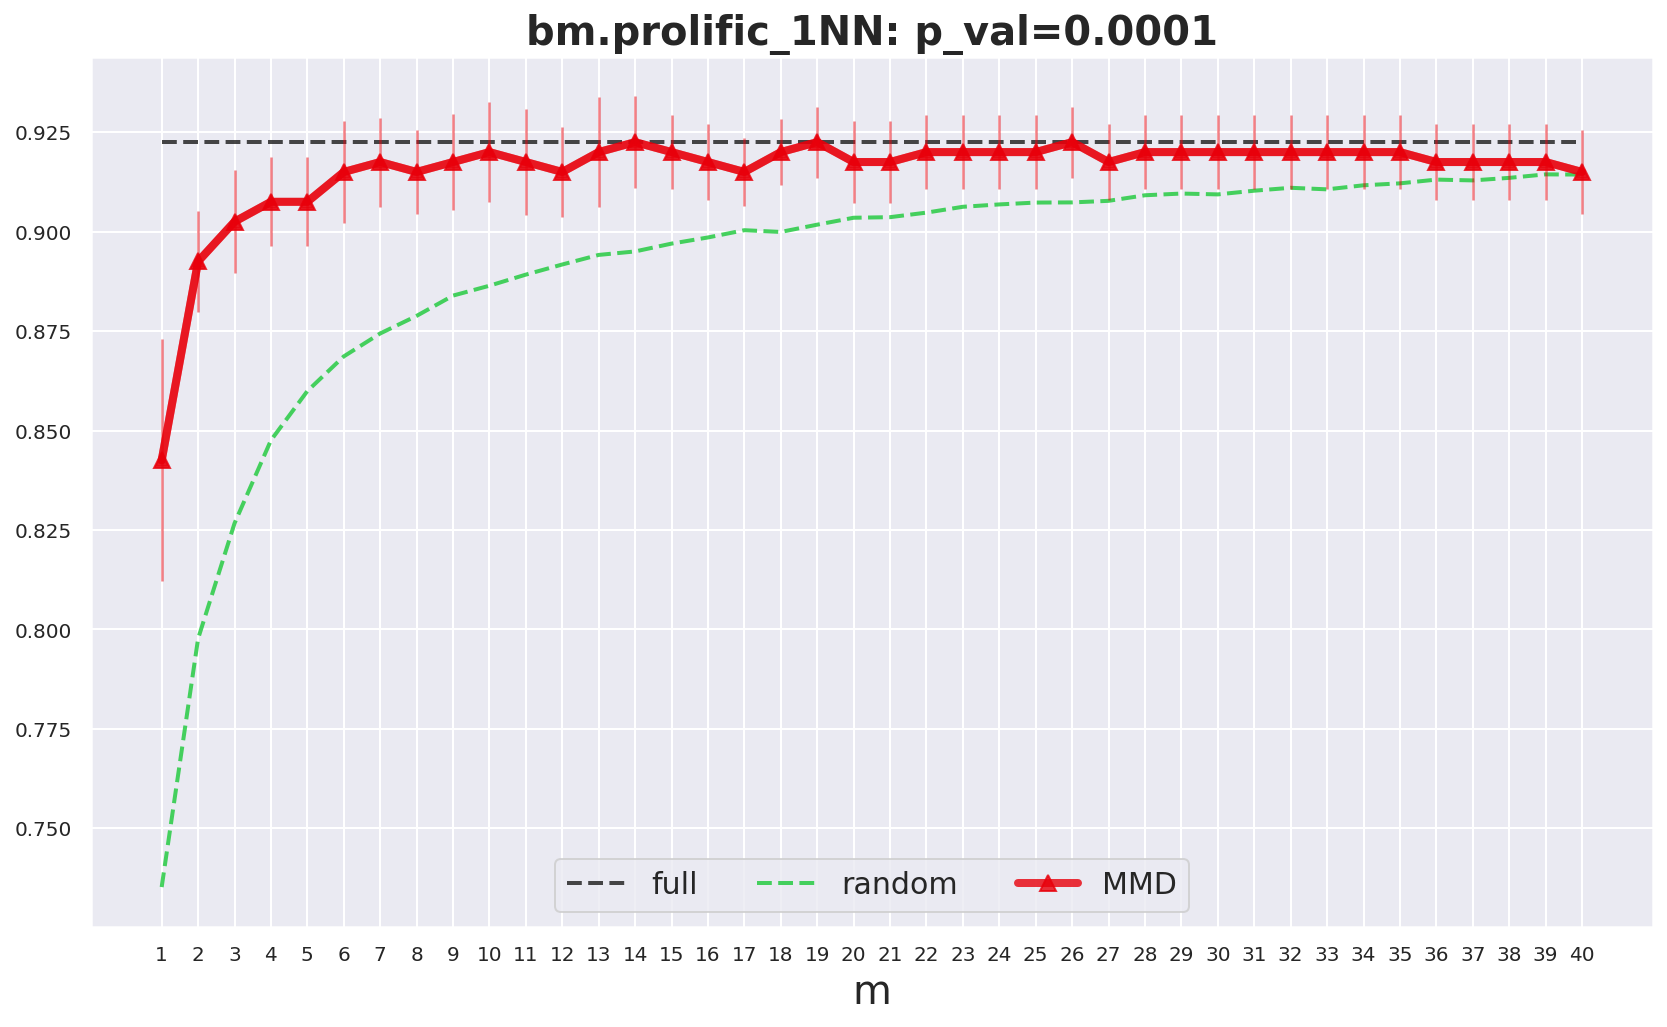

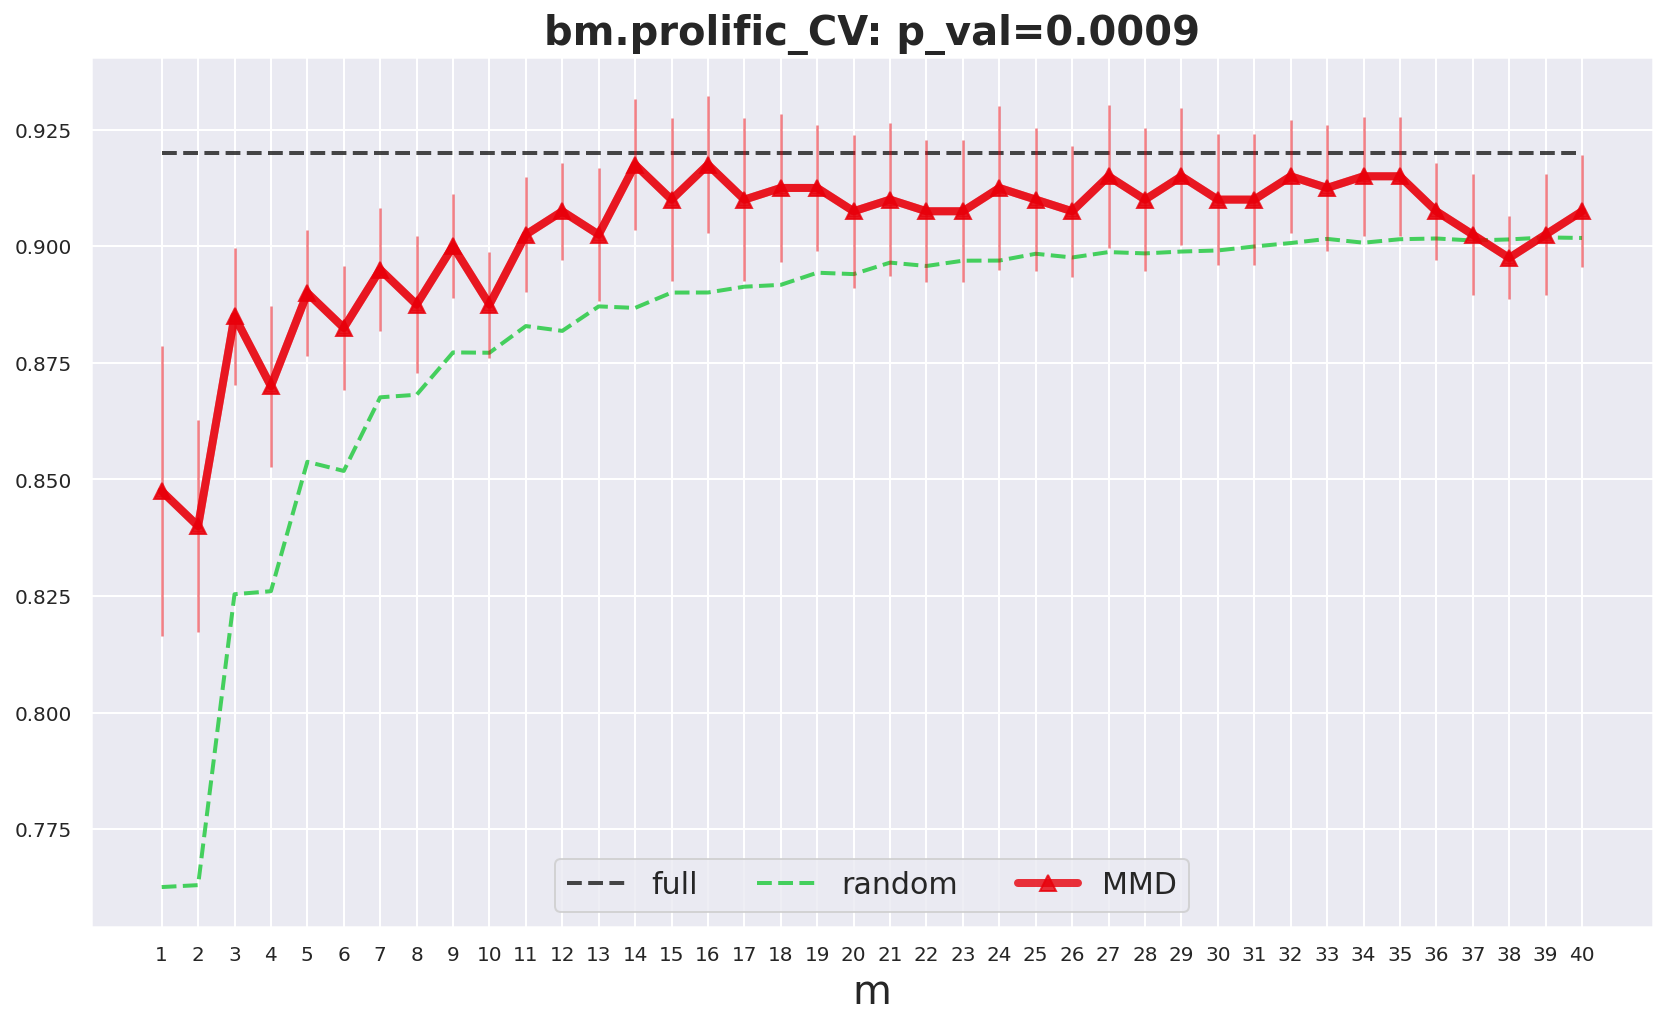

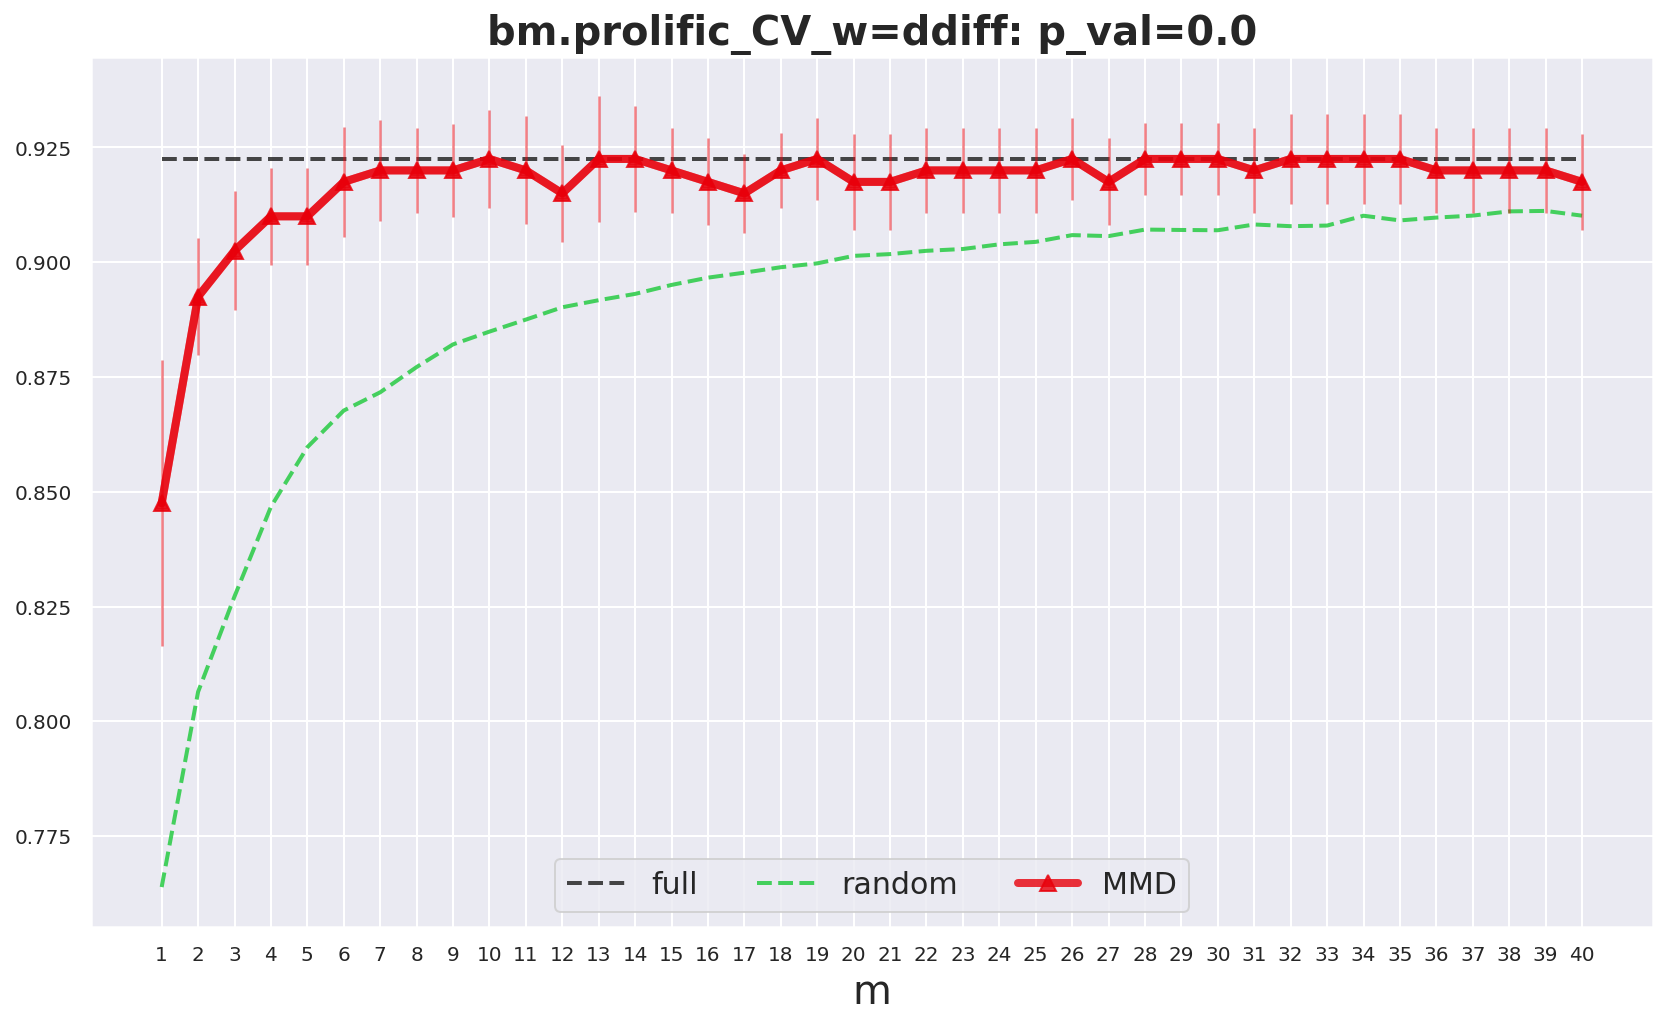

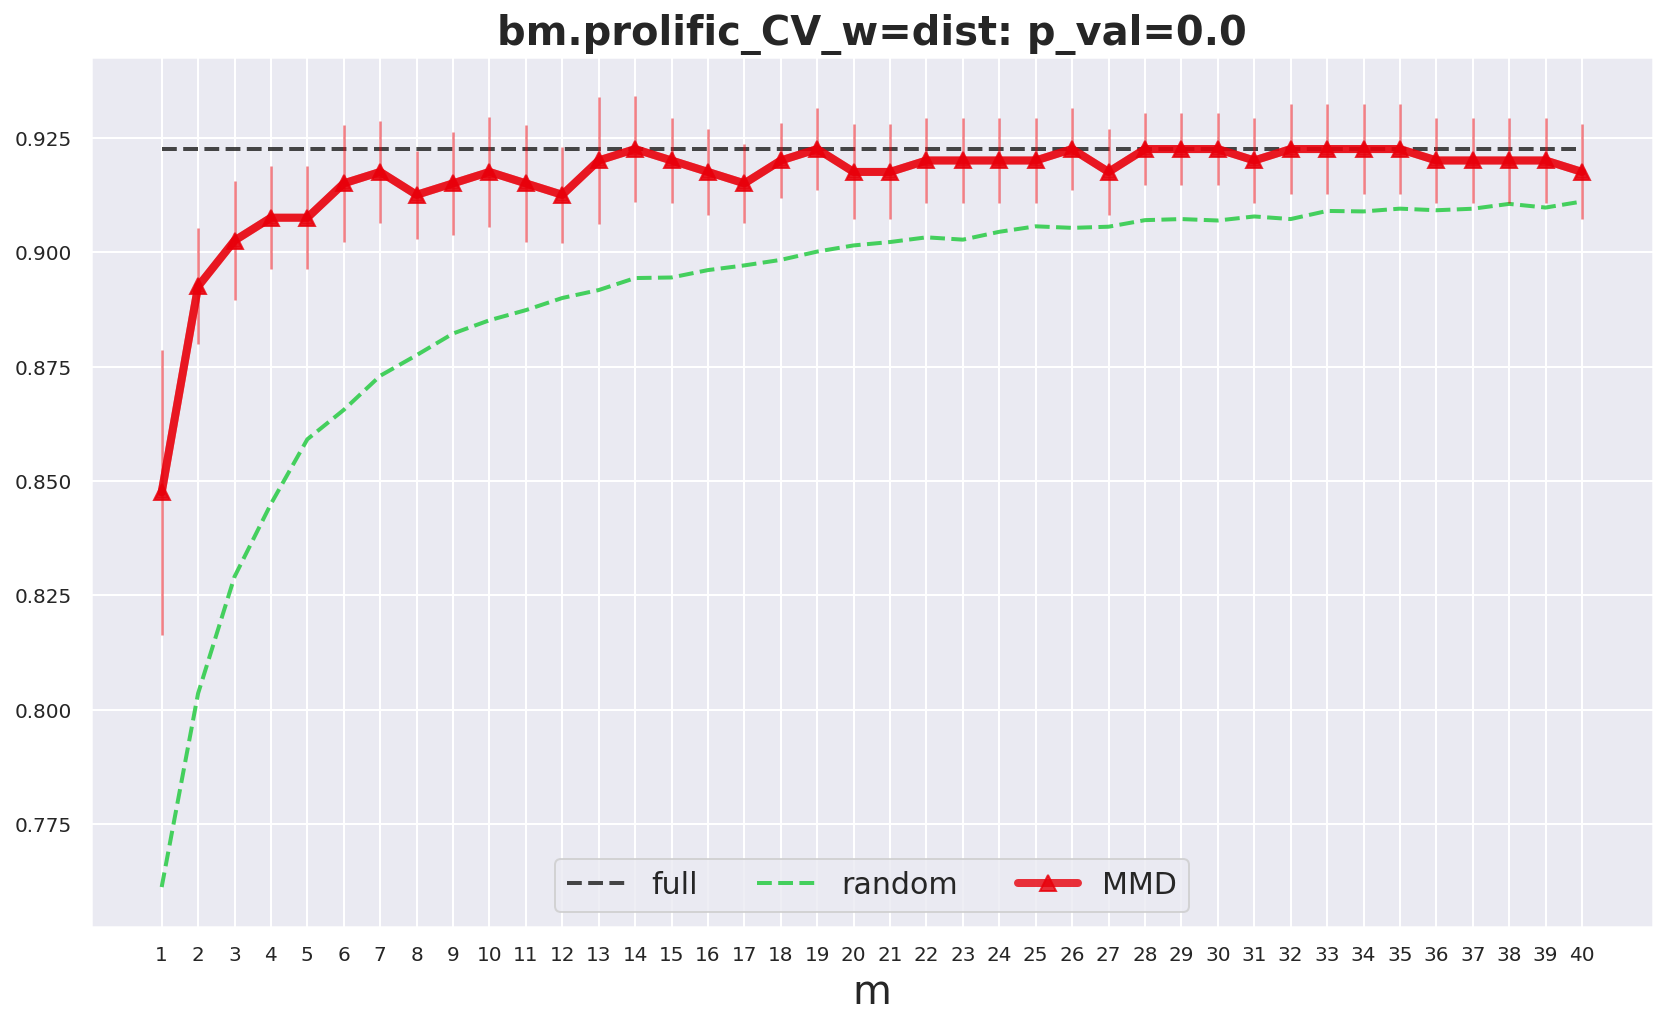

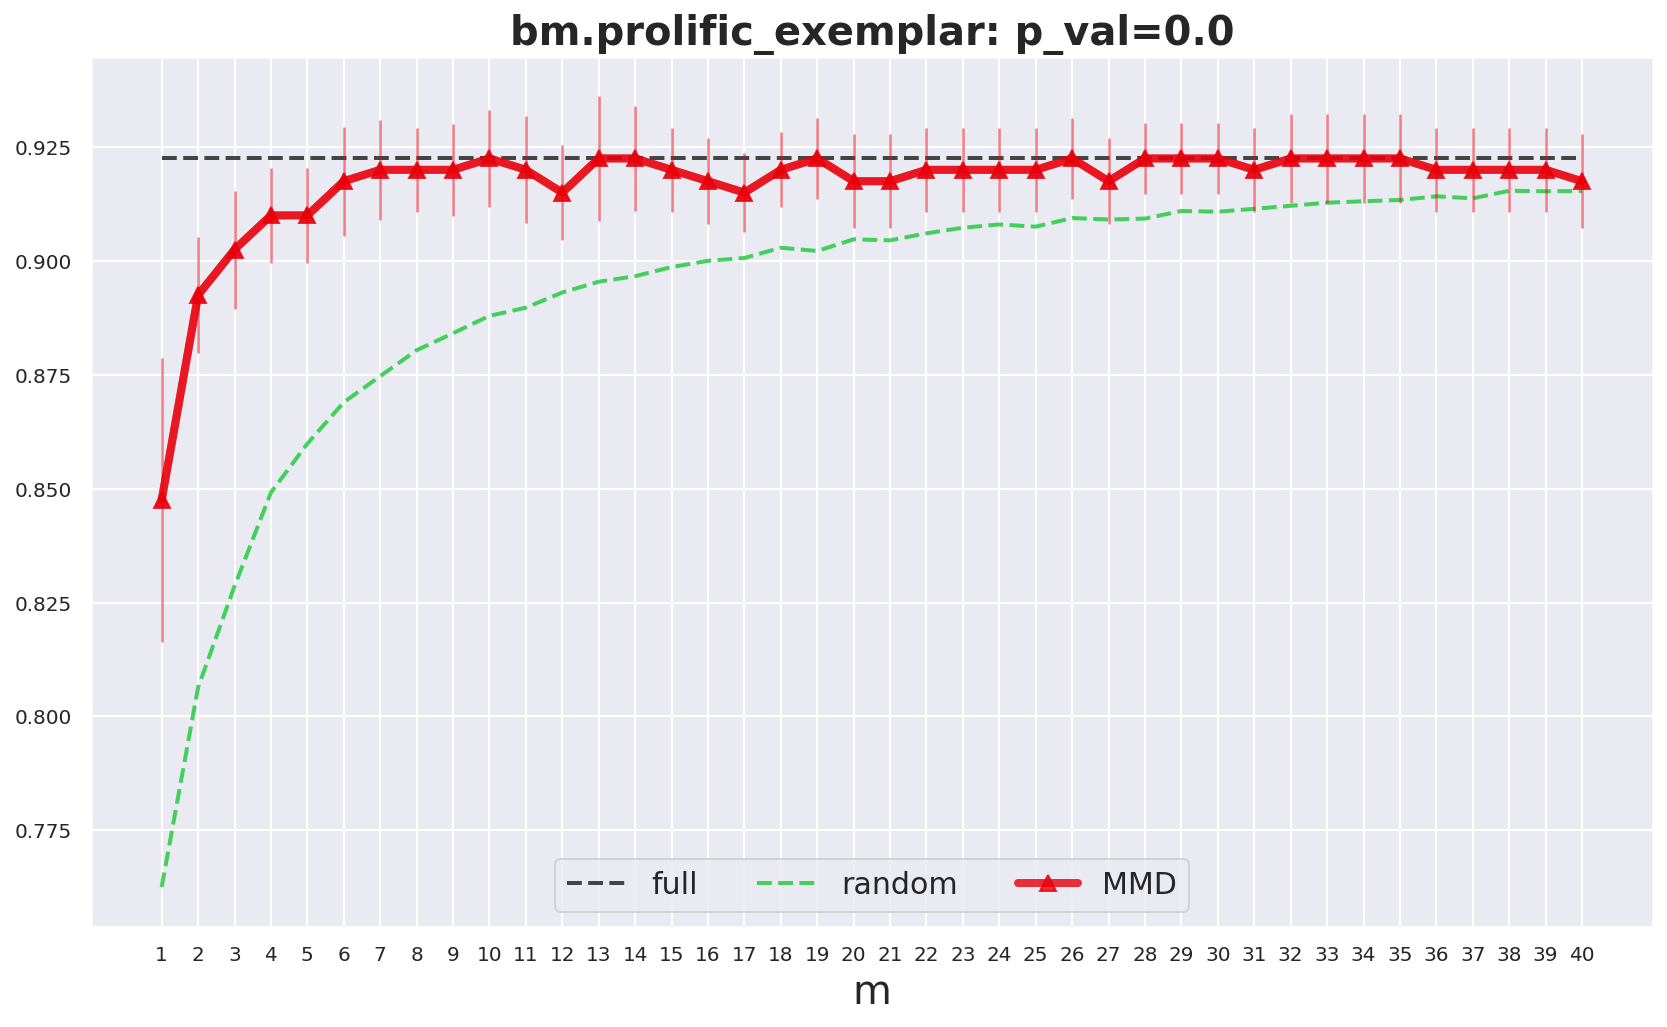

In [18]:
learners = np.unique(df['learner'])
for learner in learners:
    learner_df = df[df['learner']==learner]
    full = learner_df.iloc[0].to_list()[2:]
    random = learner_df.iloc[1].to_list()[2:]
    teach = learner_df.iloc[2].to_list()[2:]
    ste = learner_df.iloc[3].to_list()[2:]
    plot_full_rand_teach(full, random, teach, m_range, alg_name, title=f"{dataset}.{dist}_{learner}", plot_configs=plot_configs, ste=ste, save_fig=save_fig, save_dir=save_dir)

### DIFF vs. CONCAT

In [11]:
def plot_concat_diff(concat_acc, diff_acc, m_range, title):
    legend = ['CV_CONCAT', 'CV_DIFF', 'wCV_CONCAT', 'wCV_DIFF', 'CV_abs_CONCAT', 'CV_abs_DIFF']
    configs = {
                    "CV_scores":            ["r", 4, "s", "dashdot"],
                    "wCV_scores":           ["g", 4, "^", "dotted"],
                    "CV_abs_scores":        ["m", 4, "x", "solid"]}

    sns.set_color_codes("bright")
    plt.figure(figsize=(14,8))
    for score in concat_acc.keys():
        config = configs[score]
        _ = plt.plot(m_range, concat_acc[score], alpha=0.8,
        color=config[0], lw=config[1],linestyle="solid")
        _ = plt.plot(m_range, diff_acc[score], alpha=0.8,
        color=config[0], lw=config[1],linestyle="dotted")


    plt.xticks(m_range)
    plt.xlabel("m")
    plt.legend(legend, loc="lower center", ncol=len(concat_acc))
    plt.title(title)

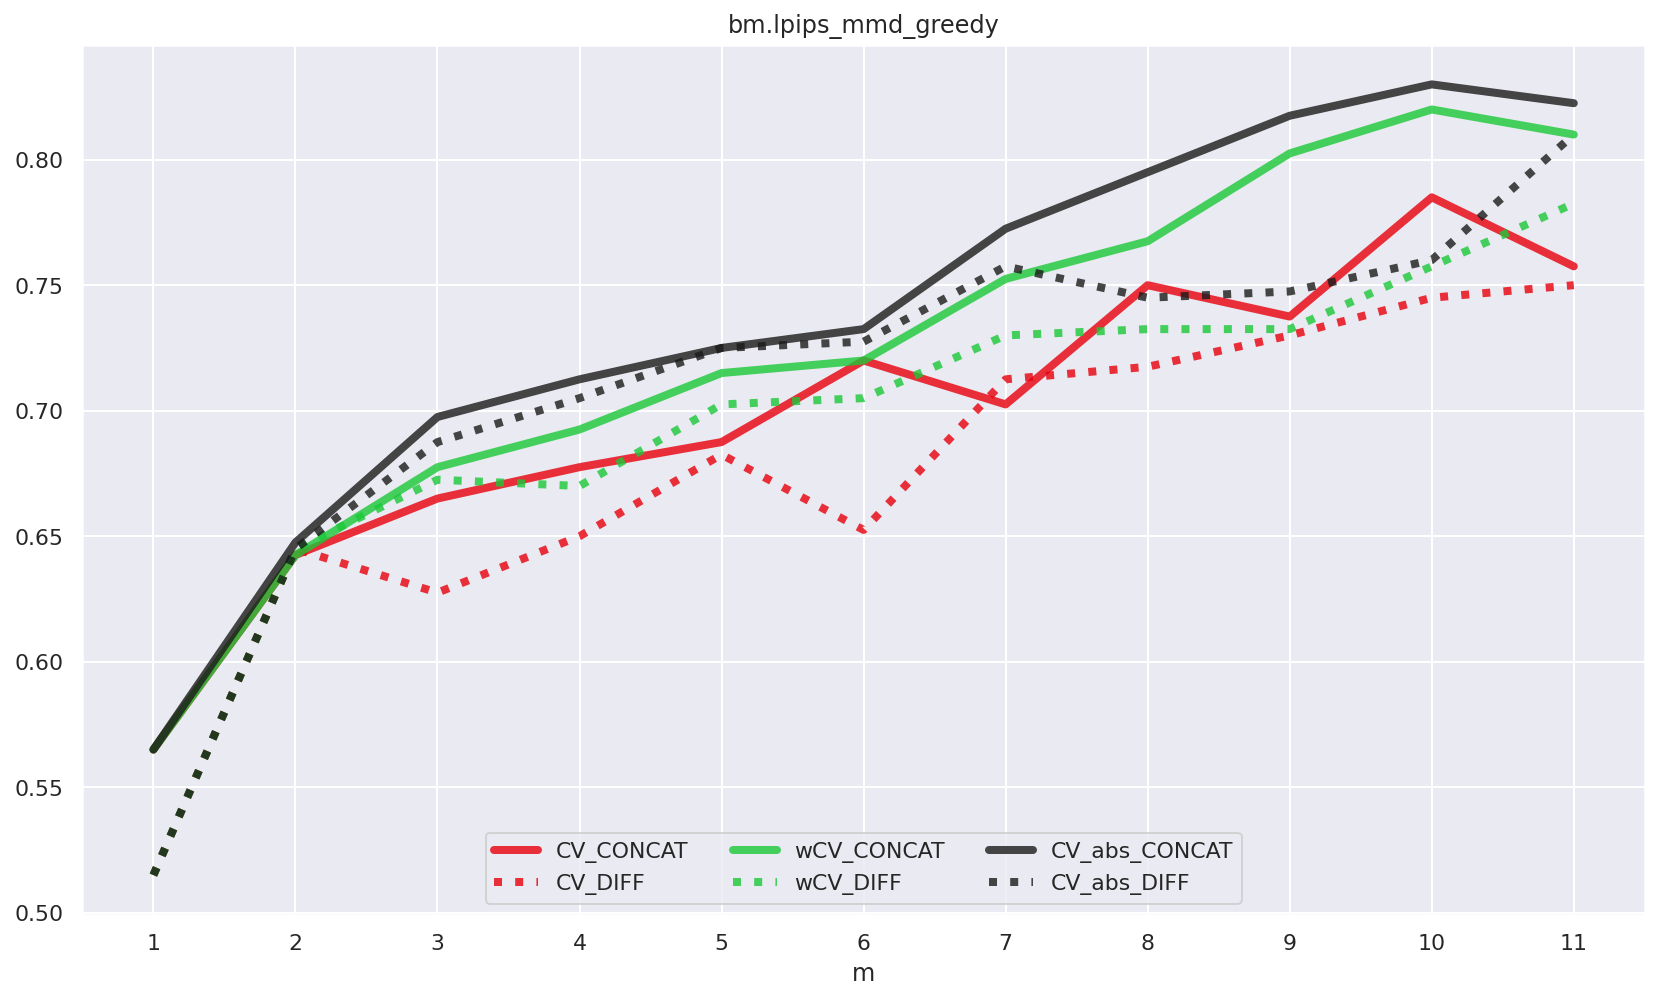

In [7]:
dataset = "bm"
seeds = np.arange(10)
dist_M, zs, y_train, y_test = get_lpips_data(dataset, seeds)
concat_zs = [evals.concat_embeds(z, y_train) for z in zs]
diff_zs = [evals.diff_embeds(z, y_train) for z in zs]

for alg, alg_name in zip(teaching_algs, alg_names):
    concat_results = [CV_experiments(m_range, dist_M, alg, paired_z, z, y_train, y_test, sim=SIM) for paired_z, z in zip(concat_zs, zs)]
    diff_results = [CV_experiments(m_range, dist_M, alg, paired_z, z, y_train, y_test, sim=SIM) for paired_z, z in zip(diff_zs, zs)]
    concat_acc = {key:np.mean(np.array([result[key] for result in concat_results]), axis=0) for key in concat_results[0].keys()}
    diff_acc = {key:np.mean(np.array([result[key] for result in diff_results]), axis=0) for key in diff_results[0].keys()}
    plot_concat_diff(concat_acc, diff_acc, m_range, f"{dataset}.lpips_{alg_name}")

11


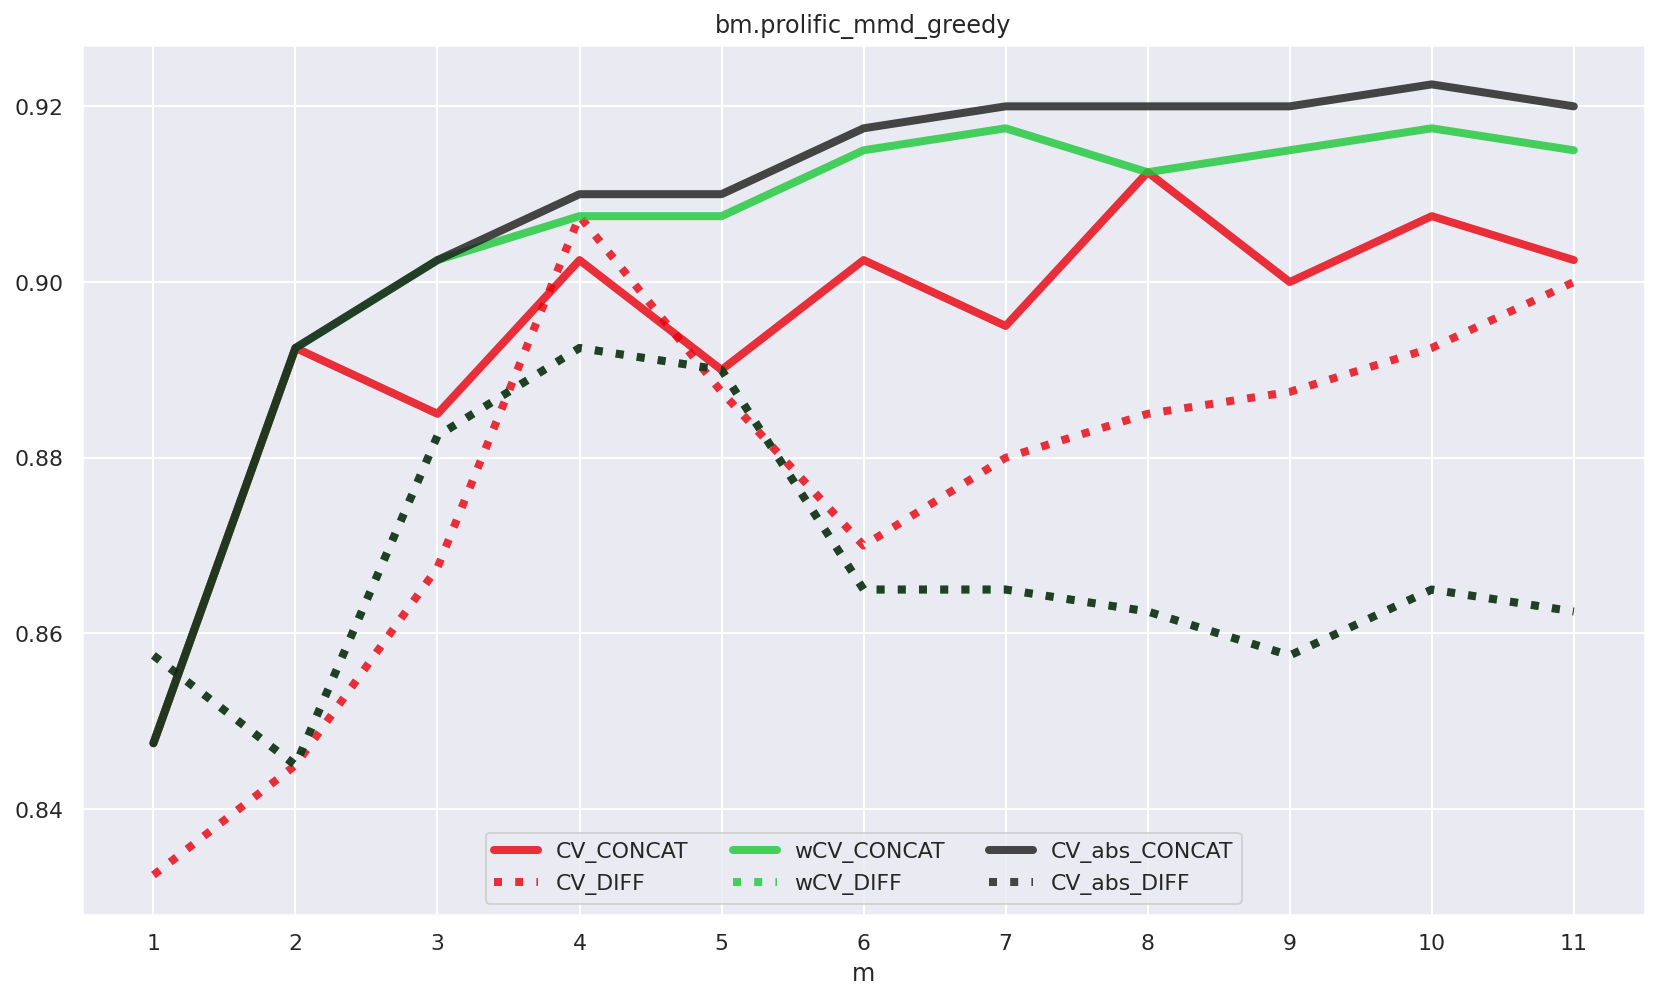

In [8]:
dataset = "bm"
seeds = np.arange(10)
dist_Ms, zs, y_train, y_test = get_prolific_data(dataset, seeds)
concat_zs = [evals.concat_embeds(z, y_train) for z in zs]
diff_zs = [evals.diff_embeds(z, y_train) for z in zs]

for alg, alg_name in zip(teaching_algs, alg_names):
    concat_results = [CV_experiments(m_range, dist_M, alg, paired_z, z, y_train, y_test, sim=SIM) for paired_z, z, dist_M in zip(concat_zs, zs, dist_Ms)]
    print(11)
    diff_results = [CV_experiments(m_range, dist_M, alg, paired_z, z, y_train, y_test, sim=SIM) for paired_z, z, dist_M in zip(diff_zs, zs, dist_Ms)]
    concat_acc = {key:np.mean(np.array([result[key] for result in concat_results]), axis=0) for key in concat_results[0].keys()}
    diff_acc = {key:np.mean(np.array([result[key] for result in diff_results]), axis=0) for key in diff_results[0].keys()}
    plot_concat_diff(concat_acc, diff_acc, m_range, f"{dataset}.prolific_{alg_name}")

In [10]:
diff_acc

{'CV_scores': array([0.8325, 0.845 , 0.8675, 0.9075, 0.8875, 0.87  , 0.88  , 0.885 ,
        0.8875, 0.8925, 0.9   ]),
 'wCV_scores': array([0.8575, 0.845 , 0.8825, 0.8925, 0.89  , 0.865 , 0.865 , 0.8625,
        0.8575, 0.865 , 0.8625]),
 'CV_abs_scores': array([0.8575, 0.845 , 0.8825, 0.8925, 0.89  , 0.865 , 0.865 , 0.8625,
        0.8575, 0.865 , 0.8625])}